Вы работаете продуктовым аналитиком в компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения. 

Вы выгрузили данные из AppMetrica за период с 1 января по 31 марта 2020, только по пользователям, зарегистрированным позднее 1 января 2020.

Обратите внимание на следующее:

- В выгрузке только уникальные действия пользователей за каждый день 

- Можно миновать стадию установки приложения, если оно было установлено ранее

- Можно миновать стадию регистрации, если пользователь был уже залогинен на момент сессии. Однако незарегистрированные пользователи не могут оформить покупку. 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-makogon/my_lessons/Product_Analytics/KC_case_data .csv', \
                parse_dates=['date'])

In [3]:
df.tail()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads
2747967,2020-03-31,register,NaN,android,11153353,female,Saint-Petersburg,-


In [4]:
df.event.value_counts()

app_start      748705
search         708639
choose_item    538669
tap_basket     377665
app_install    154597
purchase       141383
register        78310
Name: event, dtype: int64

In [5]:
# MAU февраля:

df.query('"2020-03-01" > date > "2020-01-31"').device_id.nunique()

75032

In [6]:
# Количество установок в январе:

df.query('date < "2020-02-01" and event == "app_install"').shape[0]

80297

In [7]:
# С какого платного маркетингового канала пришло больше всего новых пользователей?

df.query('event == "app_install"') \
    .groupby('utm_source', as_index=False) \
    .agg({'device_id': 'count'}) \
    .sort_values('device_id', ascending=False)

,utm_source,device_id
0,-,32460
6,yandex-direct,29368
2,google_ads,26286
5,vk_ads,23189
3,instagram_ads,20096
1,facebook_ads,13916
4,referal,9282


6. Присвойте пользователям когорты по дню установки приложения и посчитайте для них  конверсию из установки в покупку в течение 7 дней. Для какой когорты конверсия была наибольшей? Ответ впишите в формате: дд.мм.гггг

Примечание: считаем пользователя сконвертировавшимся, если с момента установки до совершения первой покупки прошло не более 7 дней.

In [8]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [9]:
df.query('device_id == 4046 and event == "app_install"')

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
2524855,2020-01-04,app_install,NaN,android,4046,female,Saint-Petersburg,-


In [10]:
df.device_id.nunique()

190884

In [11]:
# only users have installed app

u = df.query('event == "app_install"').device_id

In [12]:
df_filt_users = df.query('device_id in @u')

In [13]:
df_filt_users.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads
5,2020-01-01,app_start,NaN,android,5148476,male,Saint-Petersburg,-


In [14]:
df_filt_users['cohort'] = df.groupby('device_id')['date'].transform('min')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
df_total_users = df_filt_users.groupby('cohort', as_index=False) \
                                .agg({'device_id': 'nunique'}) \
                                .rename(columns={'device_id': 'total_users'})

In [16]:
df_total_users.head()

,cohort,total_users
0,2020-01-01,3579
1,2020-01-02,3144
2,2020-01-03,2402
3,2020-01-04,1831
4,2020-01-05,1671


In [17]:
df_filt_users.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,cohort
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-01
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,2020-01-01
5,2020-01-01,app_start,NaN,android,5148476,male,Saint-Petersburg,-,2020-01-01


In [18]:
df_purch = df_filt_users.query('event == "purchase"') \
                    .groupby(['device_id', 'cohort'], as_index=False) \
                    .agg({'date': 'min'})

In [19]:
df_purch.head()

,device_id,cohort,date
0,4046,2020-01-04,2020-01-04
1,4120,2020-01-07,2020-01-07
2,4125,2020-01-07,2020-01-07
3,4202,2020-01-08,2020-02-27
4,4234,2020-02-19,2020-02-19


In [20]:
df_purch['dif'] = df_purch['date'] - df_purch['cohort']

In [21]:
df_purch['dif'] = df_purch['dif'].dt.days

In [22]:
df_purch['dif'] = df_purch['dif'].apply(lambda x: 1 if x <= 7 else 0)

In [23]:
df_conv_users = df_purch.groupby('cohort', as_index=False) \
                        .agg({'dif': 'sum'}) \
                        .rename(columns={'dif': 'conv_users'})

In [24]:
df_cr = df_conv_users.merge(df_total_users, on='cohort', how='inner')

In [25]:
df_cr['CR'] = df_cr.apply(lambda row: row['conv_users'] / row['total_users'], axis=1)

In [26]:
df_cr.sort_values('CR', ascending=False).head()

,cohort,conv_users,total_users,CR
0,2020-01-01,1408,3579,0.393406
8,2020-01-09,558,1424,0.391854
14,2020-01-15,1650,4310,0.382831
13,2020-01-14,1973,5173,0.381403
1,2020-01-02,1186,3144,0.377226


Проанализируйте на каком этапе воронки отваливается бОльшая часть клиентов. Посмотрите отдельно сценарии для зарегистрированных и для незарегистрированных пользователей. На каком шаге отваливается больше всего зарегистрированных пользователей?

Подсказка: 

- Для того, чтобы выделить группу тех, кому нужно и не нужно регистрироваться, добавьте колонку с датой регистрации. Если дата регистрации < даты совершения события, то пользователь уже зарегистрирован. 

ВОРОНКА:

app_install – установка приложения
   
app_start – открыть приложения


registration – зарегистрироваться 


search – перейти на страницу поиска товаров (каталог)


open_item – открыть товар


choose_item – отправить товар в корзину


tap_basket – перейти в корзину


purchase – подтверждение покупки

In [27]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [28]:
df_reg = df.query('event == "register"')

In [29]:
df_reg

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
2669658,2020-01-01,register,NaN,ios,294193,female,Saint-Petersburg,instagram_ads
2669659,2020-01-01,register,NaN,ios,22917617,male,Moscow,google_ads
2669660,2020-01-01,register,NaN,android,15248490,male,Moscow,-
2669661,2020-01-01,register,NaN,android,252062,female,Moscow,vk_ads
2669662,2020-01-01,register,NaN,android,2251583,female,Moscow,instagram_ads
...,...,...,...,...,...,...,...,...
2747963,2020-03-31,register,NaN,android,2984778,male,Saint-Petersburg,facebook_ads
2747964,2020-03-31,register,NaN,ios,27301864,male,Moscow,-
2747965,2020-03-31,register,NaN,ios,1294285,female,Saint-Petersburg,google_ads
2747966,2020-03-31,register,NaN,android,3010574,female,Saint-Petersburg,google_ads


In [30]:
df_col_reg = df.merge(df_reg[['device_id', 'date']], on='device_id', how='left') \
                .rename(columns={'date_x': 'date_event', 'date_y': 'date_reg'})

In [31]:
df_col_reg.head()

,date_event,event,purchase_sum,os_name,device_id,gender,city,utm_source,date_reg
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-,2020-01-07
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads,2020-01-01
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal,2020-01-01
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads,2020-01-01
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads,NaT


In [32]:
df_col_reg.query('date_reg != "NaT"', inplace=True)

In [33]:
df_col_reg['dif'] = df_col_reg['date_reg'] - df_col_reg['date_event']

In [34]:
df_col_reg['dif'] = df_col_reg['dif'].dt.days

In [35]:
df_dif = df_col_reg.query('event == "app_start" and dif < 0')

In [36]:
a = df_dif['device_id'].unique()

In [37]:
df_ready = df.query('device_id in @a')

In [38]:
df_ready.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
5,2020-01-01,app_start,NaN,android,5148476,male,Saint-Petersburg,-
6,2020-01-01,app_start,NaN,android,8383386,female,Saint-Petersburg,vk_ads
7,2020-01-01,app_start,NaN,android,8581267,female,Saint-Petersburg,google_ads


In [39]:
df_ready.groupby('event', as_index=False) \
        .agg({'device_id': 'nunique'})

,event,device_id
0,app_install,33211
1,app_start,40991
2,choose_item,40991
3,purchase,38758
4,register,40991
5,search,40991
6,tap_basket,40991


In [40]:
# all df

df.groupby('event', as_index=False) \
        .agg({'device_id': 'nunique'})

,event,device_id
0,app_install,154597
1,app_start,190884
2,choose_item,155691
3,purchase,70875
4,register,78310
5,search,184488
6,tap_basket,125414


In [41]:
df.event.value_counts()

app_start      748705
search         708639
choose_item    538669
tap_basket     377665
app_install    154597
purchase       141383
register        78310
Name: event, dtype: int64

Пользователи, пришедшие с какого канала, имеют медианный первый чек выше?
(учитываются только первые покупки пользователей)

In [43]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [44]:
df.query('device_id == 35342310 and event == "purchase"')

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
2426626,2020-03-27,purchase,5097.5,ios,35342310,male,Moscow,facebook_ads


In [45]:
# first purchases

df_first = df.query('event == "purchase"') \
            .groupby('device_id', as_index=False) \
            .agg({'date': 'min', 'utm_source': 'unique'})
df_first

,device_id,date,utm_source
0,4014,2020-02-01,[referal]
1,4046,2020-01-04,"[-, facebook_ads]"
2,4060,2020-03-07,[yandex-direct]
3,4120,2020-01-07,"[instagram_ads, -]"
4,4125,2020-01-07,"[yandex-direct, referal]"
...,...,...,...
70870,35321120,2020-03-25,[referal]
70871,35326839,2020-03-28,[facebook_ads]
70872,35342310,2020-03-27,[facebook_ads]
70873,35367797,2020-03-29,[facebook_ads]


In [46]:
df_first['utm_source'] = df_first['utm_source'].str[0]

In [47]:
df_first

,device_id,date,utm_source
0,4014,2020-02-01,referal
1,4046,2020-01-04,-
2,4060,2020-03-07,yandex-direct
3,4120,2020-01-07,instagram_ads
4,4125,2020-01-07,yandex-direct
...,...,...,...
70870,35321120,2020-03-25,referal
70871,35326839,2020-03-28,facebook_ads
70872,35342310,2020-03-27,facebook_ads
70873,35367797,2020-03-29,facebook_ads


In [48]:
df_for_merge = df.query('event == "purchase"')

In [49]:
df_merge = df_first.merge(df_for_merge[['device_id', 'date', 'purchase_sum', 'utm_source']], \
               on=['device_id', 'date', 'utm_source'], how='left')

In [50]:
df_merge

,device_id,date,utm_source,purchase_sum
0,4014,2020-02-01,referal,86.0
1,4046,2020-01-04,-,429.5
2,4060,2020-03-07,yandex-direct,172.5
3,4120,2020-01-07,instagram_ads,598.5
4,4125,2020-01-07,yandex-direct,566.0
...,...,...,...,...
70870,35321120,2020-03-25,referal,531.0
70871,35326839,2020-03-28,facebook_ads,404.5
70872,35342310,2020-03-27,facebook_ads,5097.5
70873,35367797,2020-03-29,facebook_ads,624.0


In [58]:
df_merge.groupby('utm_source', as_index=False) \
        .agg({'purchase_sum': 'median'}) \
        .sort_values('purchase_sum', ascending=False)

,utm_source,purchase_sum
0,-,398.5
4,referal,395.5
3,instagram_ads,393.5
5,vk_ads,393.0
6,yandex-direct,392.5
2,google_ads,390.5
1,facebook_ads,389.0


Данные по затратам на рекламу:

Яндекс – 10 491 707 руб.

Гугл – 10 534 878 руб.

Фейсбук – 8 590 498 руб.

Инстаграм – 8 561626 руб.

ВК – 9 553 531руб.

Какой платный канал привлечения имеет самый высокий ROMI? 

ROMI = (доходы от маркетинга - затраты на маркетинг) / затраты на маркетинг * 100%

In [52]:
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [53]:
df_romi = df.query('utm_source != "-" and utm_source != "referal"') \
            .groupby('utm_source', as_index=False) \
            .agg({'purchase_sum': 'sum'})

In [54]:
df_romi

,utm_source,purchase_sum
0,facebook_ads,12249901.0
1,google_ads,12868276.0
2,instagram_ads,14546969.0
3,vk_ads,16389652.5
4,yandex-direct,13915368.0


In [55]:
df_romi['cost'] = [8590498, 10534878, 8561626, 9553531, 10491707]

In [56]:
df_romi['ROMI'] = (df_romi['purchase_sum'] - df_romi['cost']) / df_romi['cost'] * 100

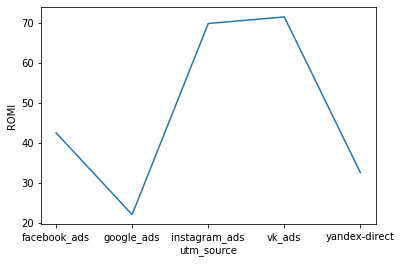

In [57]:
sns.lineplot(data=df_romi, x='utm_source', y='ROMI')